## Parametric Driving 
`scqubits` can simplify simulations of dynamics using `qutip`, by automating the building of the dynamical Hamiltonians that can be directly subsituted to `qutip`'s solver routines such as `mesolve`, `mcsolve`, etc. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as q
import scqubits as scq

Let us define a circuit and look at its spectrum

In [10]:
# Let's start by defining a fluxonium
inp_yaml = """
branches:
- [JJ, 1, 2, 4, 0.5]
- [L, 1, 2, 1.3]
- [C, 1, 2, 2]
"""
circ = scq.Circuit(inp_yaml, from_file=False, use_dynamic_flux_grouping=True, ext_basis="discretized")
circ.cutoff_ext_1 = 100
circ.Φ1 = 0.5

In [11]:
eigs = circ.eigenvals()
eigs - eigs[0]

array([0.        , 0.1734474 , 2.36189081, 3.65328642, 5.59769016,
       7.63584593])

Spectral data:   0%|          | 0/81 [00:00<?, ?it/s]

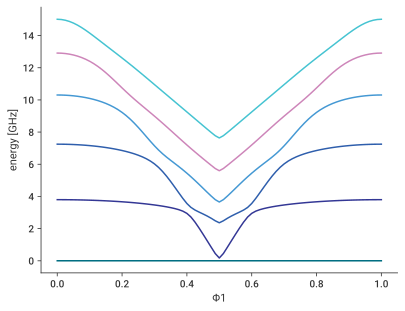

In [12]:
circ.plot_evals_vs_paramvals("Φ1", np.linspace(0, 1, 81), subtract_ground=True);

## Rabi oscillations
And study Rabi oscillations generated by modulating the flux

In [13]:
# defining Hierarchical diagonalization to limit to the lowest two states
circ.configure(system_hierarchy=[[1]], subsystem_trunc_dims=[10])

# specific form of the flux modulation  
def flux_ac(t, args):
        freq = args["freq"]
        return 0.001*np.sin(2*np.pi*freq*t)

# asking the method to return Hamiltonian when Φ1 is varied around the bias point 
# H_mesolve is the Hamiltonian to be used in the Qutip method mesolve
H_mesolve, *H_sym_ref = circ.hamiltonian_for_qutip_dynamics(free_var_func_dict={"Φ1": flux_ac}, prefactor=np.pi*2)

eigs, evecs = circ.eigensys(evals_count=5)
wf0 = q.Qobj(evecs[:, 0]) # ground state as initial state

initial_state_proj = wf0 * wf0.dag() # to see the overlap
tf = 100 # final time in nanoseconds
freq = eigs[1] - eigs[0] # transition frequency between the first two states

# evolve the system
result = q.mesolve(H_mesolve, wf0, np.linspace(0, tf, 500), args={"freq": freq}, e_ops=[initial_state_proj])

Text(0, 0.5, 'Ground state population')

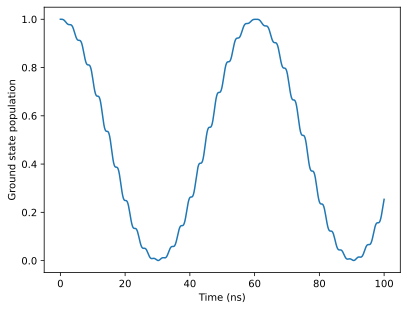

In [14]:
fig, ax=plt.subplots()
ax.plot(result.times, result.expect[0])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Ground state population')

Note that the steps like features over the sinusiod in the above plot, is because we have not used RWA in the drive Hamiltonian. 

## Example Floquet Simulation
We can also explore a Floquet simulation

In [17]:
# defining Hierarchical diagonalization to limit to the lowest two states
circ.configure(system_hierarchy=[[1]], subsystem_trunc_dims=[2])

all_eigs = []
flux_vals = np.linspace(0.48, 0.58, 61)
for flux in flux_vals:
    
    circ.Φ1 = flux
    eigs, evecs = circ.eigensys(evals_count=2)
    psi0 = q.Qobj(evecs[:, 0])
    freq = 491e-3
    
    def flux_ac(t, args):
        freq = args["freq"]
        return 0.028*np.cos(2*np.pi*freq*t)
    
    t = np.linspace(0, 1/freq, 300)
    H_mesolve, *b = circ.hamiltonian_for_qutip_dynamics(free_var_func_dict={"Φ1": flux_ac}, prefactor=np.pi*2)
    # calculating the floquet energies
    res = q.propagator(H_mesolve, t=t, args={"freq": freq})
    u_eigs = res[-1].eigenenergies()
    floquet_eigs = np.arctan2(np.real(u_eigs), np.imag(u_eigs))
    floquet_eigs.sort()
    floquet_eigs = floquet_eigs * freq / (2*np.pi)
    all_eigs.append(floquet_eigs)


Text(0, 0.5, 'Floquet energies (GHz)')

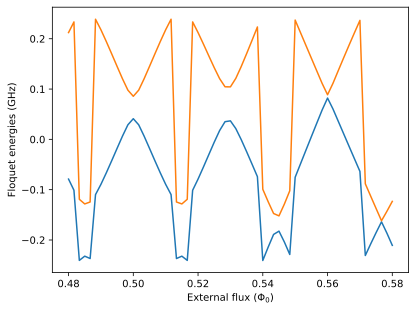

In [18]:
fig, ax=plt.subplots()
plt.plot(flux_vals, all_eigs)
ax.set_xlabel(r'External flux ($\Phi_0$)')
ax.set_ylabel('Floquet energies (GHz)')